In [10]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
from IPython.display import Image, display

# Kalman Filter

## 1. Introduction

In real world we deal with different systems: they can be physical objects like car, aircraft or robot, they can be some non-physical objects like bitcoin or the sales of certain product. In real world problems we want to track and control these systems, in other words *estimate the state* of these systems. The states of a system are those variables that provide a complete representation of the internal condition or status of the system at a given instant of time. For example in air traffic control a crucial requirement is the knowledge of the positions and the velocities of all surrounding aircraft. The position and velocity of the airplane can be described by a six-dimensional vector that changes over time. This vector subsumes all relevant information for the staff at the airport tower: it is the **system state** that we would like to *estimate*. 

The aircraft motion is determined by physical laws and as such lends itself to deriving a motion model. This model describes how the state changes over time. Obviously, that model is some kind of approximation, because we are not able to include all factors effecting to the motion of aircraft: wind, some actions that the pilot executes and many more other disturbances. In the model, such knowledge can be included as random input with a certain probability distribution. In the state estimation problem, such random inputs are called *process noise*. In summary, each aircraft has a *dynamic model which describes its motion in a probabilistic manner*.

The airport tower is equipped with radar sensors that provide information about the distance to individual aircraft and the angles in which they are approaching. Such measurements are taken at specific times and offer only a snapshot of the changing distances and angles. Furthermore, they are subject to inevitable measurement errors which are in the estimation context accounted for by another random input with a certain probability distribution: *the measurement noise*. Using simple geometry, the range and angle measurements can be related to the three-dimensional aircraft position, that is: we are able to measure the states only *partially* - only positions, so the state is partially *observable*. The functional relation between measurements and states, together with the measurement noise, yields a so called *measurement model*. 


For one aircraft, the filtering problem amounts to estimating its state based on the incoming radar measurements and the dynamic and measurement model. *The general idea is to establish a **best estimate** for the true value of some dynamical system from an incomplete, potentially noisy set of observations on that system*. 

The Kalman filter was invented by **Rudolf Emil Kalman** in 1960 to solve this kind of problem in a mathematically optimal way. Historically, it was build to estimate the position and the speed of an orbiting vehicle. Initially it was build for a *linear Gaussian system*. Later on, different generalizations and extensions of the Kalman ﬁlter were developed for nonlinear and non-Gaussian problems, such as the extended Kalman ﬁlter, the unscented Kalman ﬁlter, the decentralized Kalman ﬁlter, and the particle ﬁlter. The first major practical use of its extension was on the [Apollo](https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19860003843.pdf) missions to the moon, and since then it has been used in an enormous variety of domains. There are Kalman filters in aircraft, on submarines, and on cruise missiles. Wall street uses them to track the market. They are used in robots, in different sensors, and in laboratory instruments. Chemical plants use them to control and monitor reactions. They are used to perform medical imaging and to remove noise from cardiac signals. If it involves a sensor and/or time-series data, a Kalman filter or a close relative to the Kalman filter is usually involved.

    FIGURE 1: Picture from Apollo

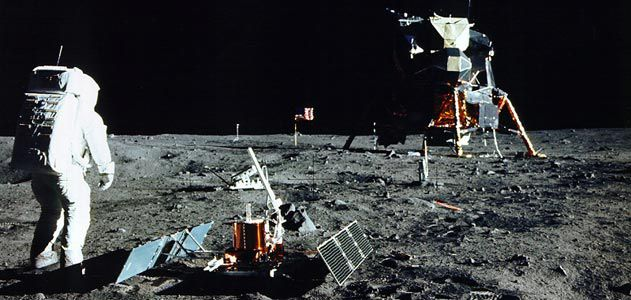

In [2]:
display(Image("images/1_apollo_image.jpeg", embed=True, unconfined=False))

    * The navigation system of Eagle lunar module AGC was based on an optimal filter - this was in the year 1969.
    * The dynamic model was Newton’s gravitation law.
    * The measurements at lunar landing were the radar readings.
    * The optimal filter was an extended Kalman filter - extension of Kalman filter for non linear systems.

## 2. Conceputal Example

This example is the simplest introductory example of Kalman filter, which is taken from [Maybeck (1979)](https://www.cs.unc.edu/~welch/kalman/media/pdf/maybeck_ch1.pdf) and slightly modified. It gives us the most essential intuitions.

Suppose that you are lost at sea during the night and have no idea at all of your location. You can infer the location by watching stars. Say you are moving on a one-dimension route.

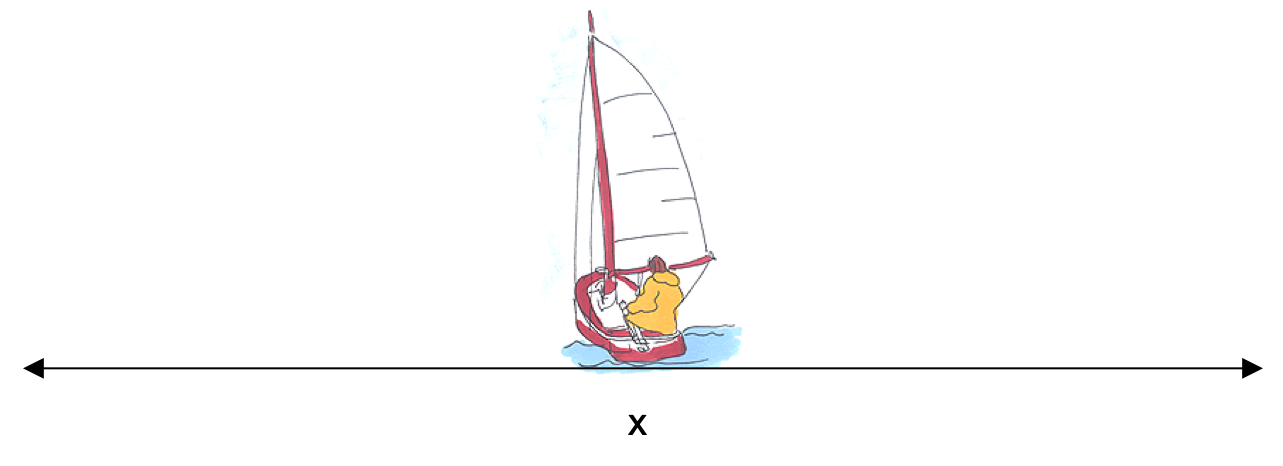

In [3]:
display(Image("images/2_boat_0.png", embed=True, unconfined=False))

Using stars at time $t_{1}$ you establish your position to be $z_{1}$ (you measure). Your measurement generally is not ideal, because there is inherent measurement device inaccuracies. You can model this inaccuracies by adding some noise term (called **measurement noise**) to your measurement. Mathematically it means that we add some random variable with zero mean and variance $\sigma_{z_{1}}^2$. By doing that we establish the **conditional probability** of $x_{1}$, your real position at time $t_{1}$, conditioned on the observed value of the measurement being $z_{1}$, as depicted in figure below. This is a plot of *conditional probability density function* - $f(x|z_{1})$ as a function of the location $x$: it tells you the probability of being in any one location range, based upon the measurement you took. Mathematically the last statement is the following:

$$
\text{probability of being between points a and b} \equiv P\big \{x \in [a, b] \: \big | \: z=z_{1} \big \} = \int_{a}^{b}f(x|z_{1})dx 
$$

    FIGURE 2: Conditional density of position based on measured value z_1.

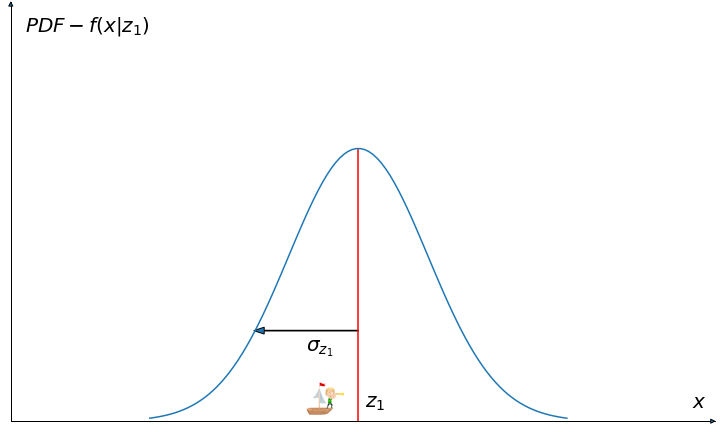

In [4]:
display(Image("images/3_boat_1.png", embed=True, unconfined=False))

It is termed a “conditional” probability density because its shape and other characteristics are dependent upon the values of the measurements taken. Its shape conveys the amount of certainty you have in the knowledge of the value of $x$. If the density plot is a narrow peak, then most of the probability “weight” is concentrated in a narrow band of $x$ values. On the other hand, if the plot has a gradual shape, the probability “weight” is spread over a wider range of $x$, indicating that you are less sure of its value. The direct measure of the uncertainty is standard deviation $\sigma_{z_{1}}$: the larger $\sigma_{z_{1}}$ is, the broader the probability peak is. 

For instance, let's model our uncertainty in measurements with Gaussian density. Mathematically it means that the actual location is a Gaussian distributed random variable with $z_{1}$ mean and $\sigma_{z_{1}}$ standard deviation:

$$
f(x|z_{1}) = 
\frac{1}{\sqrt{2 \pi \sigma_{z_{1}}^2}}e^{-\frac{(x - z_{1})^2}{2\sigma^2_{z_{1}}}}
$$


For a Gaussian density, 68.3% of the probability “weight” is contained within the band $\sigma$ units to each side of the mean. Roughly speaking it means that if after measurement you get the value $z_{1}=10$ and your measurement precision is $\sigma_{z_{1}}=3$, then the probability that your actual location is somewhere between $[10 - 3, 10 + 3]$ equals to 68.3%.

Once such a conditional probability density function is established, the ***“optimal”*** estimate of actual location can be defined. The  reasonable choice of the estimate is the ***mean of probability distribution***: the “center of probability mass”. So the estimate and the variance of the error in the estimate are: 

$$
\hat{x}_{1} = z_{1},  \\
\sigma_{x_{1}}^2 = \sigma_{z_{1}}^2.
$$

Suppose that you travel for some time before taking another measurement. Further assume that the best model you have of your motion is of the simple form

$$
\frac{dx}{dt} = v + w
$$

where $v$ is a nominal velocity and $w$ is a noise term used to represent the uncertainty in your knowledge of the actual velocity due to disturbances, off-nominal conditions, effects not accounted for in the simple first order equation, and the like. The “noise” $w$ will be modeled as a white Gaussian noise with a mean of zero and variance of $\sigma_{w}^2$.

    FIGURE 3: Propagation of conditional probability density

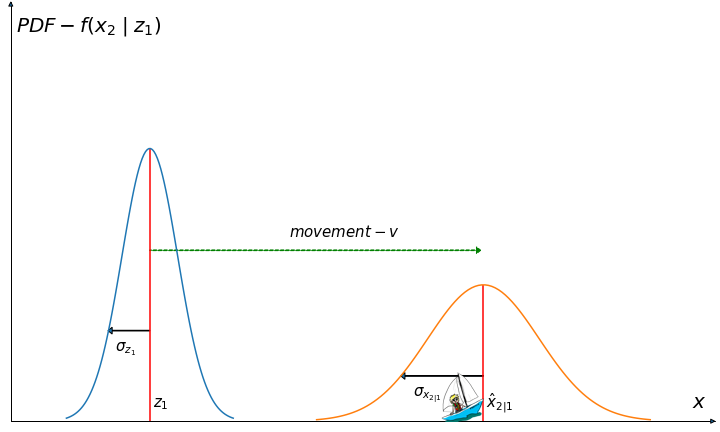

In [5]:
display(Image("images/4_boat_2.png", embed=True, unconfined=False))

Figure 3 shows graphically what happens to the conditional density of position, given $z_{1}$, due to movement. As time progresses, the density travels along the $x$ axis at the nominal speed $v$, while simultaneously spreading out about its mean. Thus, the probability density starts at the best estimate, moves according to the nominal model of dynamics, and spreads out in time because you become less sure of your exact position due to the constant addition of uncertainty over time. At the time $t_{2}$, just **before the measurement is taken** at time $t_{2}$, the density $f(x_{2} | z_{1})$ can be expressed mathematically as a Gaussian density with mean and variance given by


$$
\hat{x}_{2|1} = \hat{x}_{1} + v\Delta t
$$

$$
\sigma_{x_{2|1}}^2 = \sigma_{x_1}^2 + \sigma_{w}^2 \Delta t
$$

where

$$
\Delta t = t_{2} - t_{1}
$$


Thus, $\hat{x}_{2|1}$ is the optimal prediction of what the $x$ value is at $t_{2}$, before the measurement is taken at $t_{2}$. The $2|1$ notation indicates that this is the prediction of the location before taking measurement.

Now a measurement is taken, and its value turns out to be $z_{2}$, and its variance is assumed to be $\sigma_{z_{2}}^2$.

So now there are two Gaussian densities available that contain information about position:
* **one encompassing all the information available before the measurement,**
* **and the other being the information provided by the measurement itself.**

    FIGURE 4: Prediction - Measurement

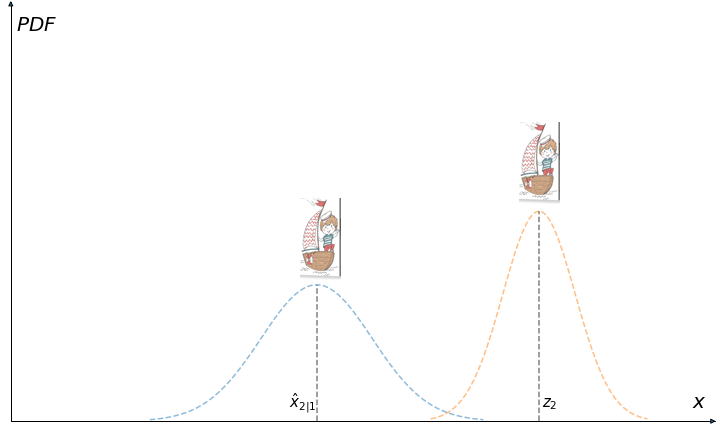

In [6]:
display(Image("images/5_boat_3.png", embed=True, unconfined=False))

The question is, **how do you combine these data?**

If we have two probabilities and we want to know the chance that both are true, we just multiply them together. So, we take the two Gaussian blobs and multiply them.

    FIGURE 5: Conditional density of position based on measured values z_1 and z_2.

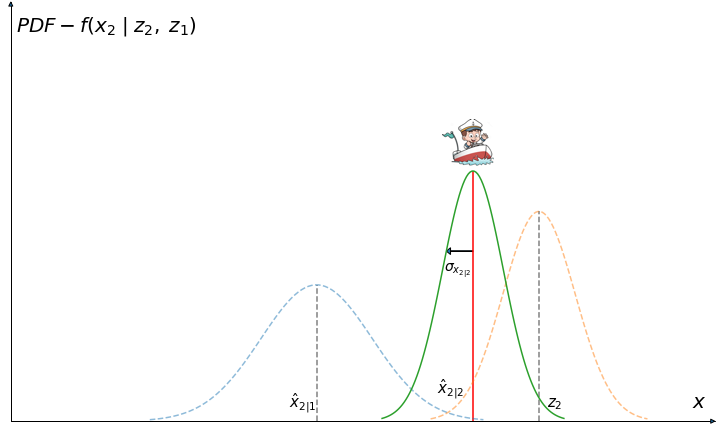

In [7]:
display(Image("images/6_boat_4.png", embed=True, unconfined=False))

As it turns out, when you multiply two Gaussian blobs with separate means and variances, you get a new Gaussian blob with its own mean and variance! We are left with the **overlap**, the region where both blobs are likely. And it’s a lot more precise than either of our previous estimates. The mean of this distribution is the configuration for which **both estimates are most likely**, and is therefore the **best guess** of the true configuration given all the information we have. Note that this intuitive multiplication and resulting distribution has strong mathematical basis in terms of **Bayes theorem** (with assumption that measurements are independent). 

So the conditional density of your position at time $t_{2}$, given **both** $\hat{x}_{2|1}$ and $z_{2}$, is a Gaussian density with the mean $\mu$ and variance $\sigma^2$ as indicated in Figure 4. 

$$ 
\mu =
\frac{\sigma_{z_{2}}^2}{\sigma^2_{x_{2|1}} + \sigma_{z_{2}}^2} \hat{x}_{2|1} +
\frac{\sigma^2_{x_{2|1}}}{\sigma^2_{x_{2|1}} + \sigma_{z_{2}}^2}z_{2}
$$

$$
\frac{1}{\sigma^2} = \frac{1}{\sigma^2_{x_{2|1}}} + \frac{1}{\sigma_{z_{2}}^2}
$$

Given this density, the best estimate is

$$
\hat{x}_{2} =
\mu =
\frac{\sigma_{z_{2}}^2}{\sigma^2_{x_{2|1}} + \sigma_{z_{2}}^2} \hat{x}_{2|1} +
\frac{\sigma^2_{x_{2|1}}}{\sigma^2_{x_{2|1}} + \sigma_{z_{2}}^2}z_{2}
$$

If we look deeper at the form of $\mu$, we can treat it is a **linear weighted average** of two estimates and each estimate **weight is proportional to the confidence** we have in that estimate. If both estimates have the same precision $\sigma^2_{x_{2|1}} = \sigma_{z_{2}}$, then the optimal estimate of position is simply the average of the two estimates, as would be expected:

$$ 
\hat{x}_{2} = \frac{1}{2}\hat{x}_{2|1} + \frac{1}{2}z_{2}
$$

On the other hand, if $\sigma^2_{x_{2|1}}$ were larger than $\sigma_{z_{1}}$, which is to say that the uncertainty involved in the estimate $\hat{x}_{2|1}$ is greater than that of $z_{2}$, then the equation dictates “weighting” $z_{2}$ more heavily than $\hat{x}_{2|1}$. Finally, the resulting estimate uncertainty $\sigma$ is less than either $\sigma^2_{x_{2|1}}$ and $\sigma_{z_{2}}$, which is to say that the **uncertainty** in your estimate of position has been **decreased by combining the two pieces of information**, i.e. even poor quality data provide some information, and should thus increase the precision of the filter output.

The equation of $\hat{x}_{2}$  can be rewritten in the following form:

$$
\hat{x}_{2} = 
[1-K_{2}] \; \hat{x}_{2|1} + K_{2}z_{2}
$$

where

$$
K_{2} = \frac{\sigma^2_{x_{2|1}}}{\sigma^2_{x_{2|1}} + \sigma_{z_{2}}^2}
$$

These equations say that the **optimal estimate** at time $t_{2}, \hat{x}_{2}$, is **equal to the weighted average  of the best prediction** of its value before $z_{2}$ is taken, $\hat{x}_{2|1}$, **plus an actual measurement** $z_{2}$. 

It is worthwhile to understand this “predict-update” structure of the filter. *Based on all previous information, a prediction of the value that the desired variables will have at the next measurement time is made. Then, when the next measurement is taken and is used to “update” the prediction of the desired variables.*

## 3. Dynamical Systems & State-Space Representation

*Finally, we make some remarks on why linear systems are so important. The answer is simple: because we can solve them!*

                                                                           Richard Feynman


#### 3.1 Overview of dynamical systems

Before moving to the state estimation problem, we should model the system dynamics and functional relation between measurements and states.

A moving aircraft is the example of **dynamical system**. The concept of dynamical systems theory has its origins in Newtonian mechanics. In physics, a dynamical system is described as a "particle or ensemble of particles whose state varies over time and thus obeys differential equations involving time derivatives." In order to make a prediction about the system’s future behavior, an analytical solution of such equations or their integration over time through computer simulation is realized. Nowadays dynamical system concept is generalized: dynamical system is all about the **evolution of something over time** (this can be the motion of some physical object, stock price, size of bacteria population and etc.). 


At any given time, a dynamical system's status is completely summarized by system's **state**. The state of a dynamic system is the smallest number of variables (called **state variables**, tuple of real numbers) such that the knowledge of these variables at $t=t_{0}$, completely determine the behaviour of the system for any time $t \geq t_{0}$. Intuitively, state variables describe enough about the system to determine its future behaviour in the absence of any unknown external forces affecting the system. The dynamical model of the dynamical system is a fixed rule that describes what future states follow from the current state. In some cases, for example in physics, formulation of a model may be rather straightforward because the governing equations are known. But in other cases involving “softer” disciplines, model development may be a tedious process where various approximations must be assessed and experiments must be done before one arrives at an adequate model representation.  
The dynamic model may be *deterministic* (for a given time interval only one future state follows from the current state) or *stochastic* (the evolution of the state is subject to random shocks). The estimation theory considers the stochastic model, since we are not able to perfectly model real world systems.

Let's see how the dynamical model looks like for the aircraft. For the simplicity we will consider that it is moving in *1D* equations. 
For simplicity we will assume that aircraft is moving in with a constant acceleration.

Let $p(t)$ denote the position, $v(t)$ the velocity, $a(t)$ the acceleration, then from kinematics we will have the following equations describing the motion of our aircraft: 

$$ 
\dot{p}(t)= v(t) \\
\dot{v}(t) = a
$$


By solving this differential equations we will have:

$$ 
v(t) = v(t_0) + a(t - t_0) \\
p(t) = p(t_0) + v(t_0)(t - t_0) + \frac{a}{2}(t - t_0)^2
$$

We can discretize this with fixed time increment $t - t_0 = \Delta t$.

$$
p_{k} = p_{k-1} + v_{k-1} \Delta t + \frac{a}{2} (\Delta t)^2 \\
v_{k} = v_{k-1} + a \Delta t
$$

We can define the **state** as

$$
{x}_{k} \equiv [p_{k}, v_{k}]^T
$$

and then the following equation will define the dynamics of our system:

$$
x_{k} = \begin{bmatrix} 1 & \Delta t \\ 0 & 1 \end{bmatrix} x_{k-1} + 
\begin{bmatrix} \frac{1}{2} (\Delta t)^2 \\ \Delta t \end{bmatrix} a = 
F_{k}x_{k-1} + B_{k}u_{k}.
$$

The equation $x_{k} = F_{k}x_{k-1} + B_{k}u_{k}$ models our system dynamics (in our example the system is the aircraft, its state is its position and velocity). This equation is applicable for linear systems and can be easily generalised for all systems:

$$
x_{k} = f_{k}(x_{k-1},u_{k}).
$$

The function $f_{k}$ is nonlinear in the general case, and can be different for different steps. This function - model may be justified by some physical laws (in the case for instance of a aircraft), or by some empirical analysis (in the case of finance). The state of the system at any time step is a function of the state of the system at the previous time step and the external control inputs applied to the system during that interval. Control inputs are external factors effecting on system state (e.g. pressing the accelerator in car makes it accelerate, gravity causes balls to fall, news about stolen bitcoins from some markets are causing bitcoin price decrease). Therefore, if the initial state $x_{0}$ is known **exactly** and the system dynamics is **modeled perfectly** by the $f_{k}$, the evolution of the state over time can be computed precisely as shown in below figure.

    FIGURE 6: System dynamics

display(Image("images/7_system_dynamics.jpeg", embed=True, unconfined=False))

In general however, the system dynamics and control inputs may not be known precisely. In our case with the aircraft, we are not able to take into consideration all the forces impacting on it (for example wind, other aerodynamic effects). In order to include all these inaccuracies and uncertainties to our model, we add another term called **process noise**:

$$
{x}_{k} = f_{k}(x_{k-1}, u_{k}, w_{k})
$$

We use process noise $w$ to represent random factors that are difficult to model precisely, for example, the wind effect. So generally we have *dynamic model which describes the dynamics of a system in a probabilistic manner*.

These inaccuracies may cause the state computed by the model to diverge unacceptably from the actual state over time. To avoid this we can make measurements. Using measurements, we would like to change the value of our model parameters to reflect our improved understanding of the state dynamic. We would proceed in two steps: make a prediction based on system dynamic model (state evolution rule) and then a correction based on what we measured. There is a subtleties here. What we measure does not have to be exactly the states. It has to be related but not the same. For instance, with our aircraft example we can measure only the position, while the state is position and velocity.

In general, the measurements themselves are imprecise.

Let's continue our example of the aircraft. As we said we can measure the position of the aircraft using radars. Let $z(k)$ is the measured position of the aircraft, then the measurement equation is

$$
z(k) = \begin{bmatrix} 1 & 0 \end{bmatrix} x(k) = H_{k}x(k).
$$

The more general form of the equation is the following:

$$
z_{k} = h_{k}(x_{k}).
$$

On the other hand we know that measurements are generally noisy. For including noise in the measurement model we add a therm called **measurement noise**:

$$
z_{k} = h_{k}(x_{k}, r_{k}).
$$

We use measurement noise $r$ to represent random noise that is in the measurements. 

#### 3.2 State-Space representation

State dynamics model together with measurement model are called **state-space representation** of a dynamical system. Usually dynamical systems in nature are *contionious-time* rather than a *discrete-time*, but in a practical application most physical systems are *discretely sampled*. In other words, in practice a digital computer performs online computations using data samples from a continuous-time dynamic system, generally taken at a fixed sample rate. That is why we will consider only *discrete-time systems*.

*Discrete-time system state-space model:*

* dynamic model: ${x}_{k} = f_{k}(x_{k-1}, u_{k}, w_{k})$
* measurment model: $z_{k} = h_{k}(x_{k}, r_{k})$

By using system state dynamic model we can **predict** the future states based on the current state. By using measurements we can indirectly **measure** the state. The issue is that both sources are noisy: the prediction is noisy because perfectly modeling a system is impossible except for the most trivial problems, the measurements are noisy due to different reasons (fundamental limitations, technological limitations, influence of external factors and etc.).

Initially Rudolf Kalman invented a solution to this problem for the **linear** systems. Extensions and generalizations to the method have also been developed, such as the *extended Kalman filter* and the *unscented Kalman filter* which work on nonlinear systems. We will start also with linear systems. In case of linear system all functional relationships in the system are linear, so $f$ and $h$ are replaced by some matrices. 

*Discrete-time linear system state-space model:*

* dynamic model: ${x}_{k} = F_{k}x_{k-1} + B_{k}u_{k} + w_{k}$
* measurment model: $z_{k} = H_{k}x_{k} + r_{k}$

    Examples

State-Space representation of dynamical system is very general approach. A lot of simple models like linear regression, AR, ARMA and many others can be formulated in a spate-space form.

* Linear regression

$$
z_{k} = a_{0} + a_{1}s_{k} + \epsilon_{k},
$$ 

where $\epsilon_{k}$ is the noise, $s_{k}$ is known variable and we would like to estimate regression coefficients $a_{0}$ and $a_{1}$. If we define a matrix $H=[1, s_{k}]$ and state vector $x=[a_{0}, a_{1}]^T$, then we will have

$$
z_{k} = Hx + \epsilon_{k}
$$

For notation sake we can also define $x_{k} = x$ such that $x_{k} = x_{k-1}$: 

$$
x_{k} = x_{k-1} \\
z_{k} = Hx_{k} + \epsilon_{k}
$$

* Autoregressive model
$$
z_{k} = w_{1}z_{k-1} + \dots + w_{d}z_{k - d} + \epsilon_{k},
$$ 

where $\epsilon_{k}$ is the noise, and we would like to estimate weights $w_{i}$ using data. If we define a matrix $H_{k}=[z_{k-1} \dots z_{k-d}]$ and state vector $x_{k}=[w_{1} \dots w_{d}]^T$, then we will have

$$
x_{k} = x_{k-1} \\
z_{k} = H_{k}x_{k} + \epsilon_{k}.
$$

#### 3.3 Probabilistic State-Space representation

The state dynamics equation is propagated forward from the initial state $x_{0}$. For any particular operation of the real system, the initial state assumes a specific value $\hat{x}_{0}$. However, from the practical point of view, if it is impossible to measure $x$, exactly for arbitrary $k$, it is unlikely that $x_{0}$, will be available exactly. This leads us to the adoption of a random initial condition for the system. So we assume that is distributed according to some *prior distribution* $p(x_{0}) \equiv p(x_{0}|z_{0})$ with mean value $\hat{x}_{0|-1}$ and covariance matrix $P_{0|-1}$, where $z_{0}$ is the set of no measurements.

Since the initial state is considered as random variable and we have random noises included in the models, we describe system dynamics and measurement models in a probabilistic manner. In other words the system dynamics model ${x}_{k} = f_{k}(x_{k-1}, u_{k}, w_{k})$ gives not exact value of the next state, but instead it gives some probability distribution function of the next state, which depends on the previous state: $x_{k} \sim p(x_{k}|x_{k-1})$. The same is valid for the measurement model, $z_{k} = H_{k}x_{k} + \epsilon_{k}$ gives some probability distribution function: $z_{k} \sim p(z_{k}|x_{k})$. 


*Probabilistic system state-space model:*

* initial state: $x_{0} \sim p(x_{0}) \equiv p(x_{0}|z_{0})$
* dynamic model: ${x}_{k} = f_{k}(x_{k-1}, u_{k}, w_{k}) \Leftrightarrow p(x_{k}|x_{k-1})$
* measurement model: $z_{k} = h_{k}(x_{k}, r_{k}) \Leftrightarrow p(z_{k}|x_{k})$

Please note that in this formulation we assume that the dynamic model $p(x_{k}|x_{k - 1})$ is Markovian process:

$$
p(x_{k}|x_{1 : k - 1}, z_{1 : k - 1}) = p(x_{k}|x_{k - 1})
$$

and the measurements $z_{k}$ are conditionally independent given $x_{k}$:

$$
p(z_{k}|x_{1 : k} , z_{1 : k - 1}) = p(z_{k}|x_{k}).
$$

## 4. Kalman Filter

#### 4.1 Problem statement 

         The most probable value of the unknown quantities will be that in which the sum of the squares of the dif-ferences between the actually observed and the computed values multiplied by numbers that measure the degree of precision is a minimum.

                                                                     Karl Friedrich Gauss

###### System description

There is a *linear* dynamical system, which is considered is composed of two essential ingredients. First, the state is assumed to be described by 

$$
{x}_{k} = F_{k}x_{k-1} + B_{k}u_{k} + w_{k}
$$

and the measurement data are related to the state by

$$
z_{k} = H_{k}x_{k} + r_{k}
$$

where $\{w_{k}\}$ and $\{r_{k}\}$ represent independent white-noise sequences, they are uncorrelated, have zero mean and covariances described by

$$
E[w_{k}] = 0, \quad 
E[w_{k}w_{j}^T] = Q_{k}\delta_{kj}, \quad 
$$

and 

$$
E[r_{k}] = 0, \quad 
E[r_{k}r_{j}^T] = R_{k}\delta_{kj}, \quad 
E[r_{k}w_{j}^T] = 0  \text{, for all } k \text{ and } j, \quad
$$

where $\delta_{kj}$ is is the Kronecker symbol. 

Initial state $x_{0}$ is distributed according to some *prior distribution* $p(x_{0}) \equiv p(x_{0}|z_{0})$ with mean value $\hat{x}_{0|-1}$ and covariance matrix $P_{0|-1}$, where $z_{0}$ is the set of no measurements. We assume also that initial state is independent of the system and measurement noise sequences. This prior distribution includes all that is known and unknown about the initial state prior to the availability of any observational data.

$$
E[w_{k}x_{0}^T] = 0, \quad
E[r_{k}x_{0}^T] = 0.
$$

The notation $\hat{x}_{i|j}$ means the state estimate at time step $i$ given measurements up to time step $j$: $z_{1}, z_{2}, \dots, z_{j}$.

###### Problem

Our problem is the estimation of the state of a time-varying system which is indirectly observed through noisy measurements, i.e. ***an estimate $\hat{x}_{k|k}$ of the state $x_{k}$ is to be computed from the measurement data $z_{1}, z_{2}, \dots, z_{k}$ so as to minimize the mean square error in the estimate***. 

#### 4.2 Kalman filter as a Bayesian Estimator

        The most we can know is in terms of probabilities.

                                      Richard Feynman


Since system dynamics and measurement models are describing the behavior of the system in a probabilistic manner, filtering problem can be treated as a *Bayesian estimation problem*. The general problem of Bayesian estimation is the estimation of an unobserved *random value* $\theta$ based on some observed *random value* $z$. To find a suitable estimator we define a cost function, $L$, which defines a penalty for an erroneous estimate $\hat{\theta} \neq \theta$. In general, we would prefer cost functions where the penalty increases based on the magnitude of the difference error $e = \theta - \hat{\theta}$. Generally Bayesian estimators are defined by a minimization problem

$$
\hat{\theta} = \underset{\theta}{\mathrm{argmin}}\iint L(e)p(\theta, z)d\theta dz
$$

which seeks for the value of $\hat{\theta}$ that minimizes the average cost (the expected value of the cost function). If the cost function is the quadratic function $L(e) = ee^T$, then the solution of the minimization problem will minimize the *mean square error* and that solution is the conditional expectation of $\theta$ given $z$ or the *mean of the posterior distribution* - $p(\theta|z)$

$$
\hat{\theta}_{MMSE} = \underset{\theta}{\mathrm{argmin}}\iint ee^Tp(\theta, z)d\theta dz = \int \theta p(\theta|z)d\theta = E[\theta|z].
$$

If we summarize, we can state that from Bayesian perspective the state estimation problem is turned into the problem of an estimation of the conditional posterior density $p(x_{k}|Z_{k})$ and then the MMSE estimator of $x_{k}$ is the mean of posterior PDF, i.e. $x_{MMSE} = E[x_{k}|Z_{k}]$, where with $Z_{k}$ we denoted all the measurements including time step $k$: $Z_{k} \equiv \{z_{1} z_{2} \dots z_{k}\}$. In other words, ***the optimal estimate of the state is the mean of the state vector probability distribution conditioned on having the full set of measurements and the optimality criterion is the mean square error:***


$$
\hat{x}_{k|k} = E[x_{k}|Z_{k}] = \int x_{k}p(x_{k}|Z_{k})dx_{k}.
$$

This provides us general formula for optimal state estimation, but unfortunately this is only conceptual solution, because procedure is computationally expensive since it often requires multidimensional integration. So it turns out that in many cases it is not possible to determine the analytical expression of the MMSE estimator. 

However, in case of *Gaussian* distributions this approach enables us to write out an explicit expression for the MMSE estimate in recursive form and this solution is the *Kalman filter*.

#### 4.3 Kalman filter: Gaussian case

First we will derive Kalman filter equations in case of Gaussian distributions. So will assume that initial state and noise terms are Gaussian distributed random variables:

$$
x_{0} \sim N(\hat{x}_{0|-1}, P_{0|-1}), \quad w_{k} \sim N(0, Q_{k}),  \quad r_{k} \sim N(0, R_{k}).
$$


We are going to consider two measurement times, $k-1$ and $k$, and will propagate optimal estimates from the point just after the measurement at time $k-1$ has been incorporated into the estimate, to the point just after the measurement at time $k$ is incorporated. Suppose we are at time $k-1$ and have just taken and processed the measurement $z_{k-1}$. From a Bayesian point of view, we are really interested in the probability density for $x_{k-1}$ conditioned on the entire measurement history to that time, $p(x_{k-1}|Z_{k-1})$, and how this density can be propagated forward through the next measurement time to generate $p(x_{k}|Z_{k})$. Once the densities are described explicitly, the optimal estimate of the state at time $k$ can be determined as a mean of it. Computation is based on recursion rule for incorporation of the new measurement $k$ into the posterior:

$$
p(x_{k-1}|Z_{k-1}) \to p(x_{k}|Z_{k})
$$


To start the derivation, we will *assume* that $p(x_{k-1}|z_{1:k-1})$ is a Gaussian conditional density:

$$
p(x_{k-1}|z_{1:k-1}) = N(\hat{x}_{k-1|k-1}, P_{k-1|k-1})
$$

where we define $\hat{x}_{k-1|k-1}$ and $P_{k-1|k-1}$ to be conditional mean and conditional covariance, respectively:

$$
\hat{x}_{k-1|k-1} = E[x_{k-1}|Z_{k-1}] \\
P_{k-1|k-1} = E[(x_{k-1} - \hat{x}_{k-1|k-1})(x_{k-1} - \hat{x}_{k-1|k-1})^T|Z_{k-1}].
$$

We will be able to verify this assumption, and in fact this can be visualized as an inductive proof type of derivation, since $p(x_{0}) \equiv p(x_{0}|Z_{0})$ is assumed to be a Gaussian density $N(\hat{x}_{0|-1}, P_{0|-1})$. The following derivation considers the case from time $k-1$ to time $k$, and combining this with the results from $k=0$ to $k=1$, would complete an inductive proof.

Recall that we want to propagate the conditional density and associated estimate from time $k-1$, just after incorporating the measurement $z_{k-1}$, to time $k+1$, just after incorporating $z_{k}$. Let us decompose this into two steps:
* 1. a time propagation from $k-1$ to $k|k-1$, at time $k$ just before the measurement $z_{k}$ is incorporated, and 
* 2. a measurement update from $k|k-1$ to $k|k$.

**Predict**

The first step usually is called *prediction step*. From the Bayesian point of view, we want to establish the conditional density of the state at time $k$, conditioned on the measurement history up through the previous sample time $k-1$: $p(x_{k}|Z_{k-1})$. Conceptually it means that having the best estimate $\hat{x}_{k-1|k-1}$ at time $k-1$  the system dynamics models predicts the state of the system for time $k$ just before taking the measurement $z_{k}$. This prediction is done based on system dynamics model ${x}_{k} = F_{k}x_{k-1} + B_{k}u_{k} + w_{k}$. As a linear combination of two Gaussians the predicted state is also Gaussian distributed vector and its mean and covariance computed by the following equations:

$$
p(x_{k}|Z_{k-1}) = N(\hat{x}_{k|k-1}, P_{k|k-1}) \\
\hat{x}_{k|k-1} = F_{k}\hat{x}_{k-1|k-1} + B_{k}u_{k} \\
P_{k|k-1} = F_{k}P_{k-1|k-1}F_{k}^T + Q_{k}.
$$

The predicted state estimate $\hat{x}_{k|k-1}$ is also known as the *a priori state estimate* because, although it is an estimate of the state at the current timestep, it *does not include observation* information from the current timestep.

**Update**

In the update phase, the current a *priori prediction is combined with current observation* information to refine the state estimate. This improved estimate is termed the *a posteriori state estimate*. In other words, we will incorporate measurement $z_{k}$ that becomes available at time $k$, so as to generate the density $p(x_{k}|Z_{k})$. Repeated application of Bayes’ rule will allow us to write this density in terms of three other densities, each of which can be evaluated rather easily. 

$$
p(x_{k} | Z_{k}) = \frac{p(x_{k}, Z_{k})}{p(Z_{k})} =
\frac{p(x_{k}, z_{k}, Z_{k-1})}{p(z_{k}, Z_{k-1})} = 
\frac{p(z_{k}|x_{k}, Z_{k-1})p(x_{k}|Z_{k-1})p(Z_{k-1})}{p(z_{k}|Z_{k-1})p(Z_{k-1})} = 
\frac{p(z_{k}|x_{k})p(x_{k}|Z_{k-1})}{p(z_{k}|Z_{k-1})}.
$$

The $p(z_{k}|Z_{k-1})$ is computed in the *predict* stage. Now we have to compute the other two parts from the left part of the equation. 

Lets start from $p(z_{k}|x_{k})$. We desire the density function for the random variable $z_{k}$, conditioned upon the fact that we know $x_{k}$ has assumed the realization $\xi$. That fact fixes the random variable $H_{k}x_{k}$ at the single known value of $H_{k}\xi$, with no uncertainty. So conditioned on $x_{k}$ the $p(z_{k}|x_{k})$ is the linear combination of some known vector and random Gaussian variable $r_{k}$. It means that $p(z_{k}|x_{k})$ is also Gaussian variable: 

$$
p(z_{k}|x_{k}) = N(H_{k}x_{k}, R_{k}).
$$

Now we will focus on the denominator. The measurement is again described by the measurement equation $z_{k}=H_{k}x_{k} + r_{k}$, but now we are conditioning only on knowledge of the previous time history of measurements $Z_{k-1}$. From formula for conditional probabilities we have

$$
p(x_{k}, r_{k}|Z_{k-1}) = p(r_{k}|x_{k}, Z_{k-1})p(x_{k}|Z_{k-1})= p(r_{k})p(x_{k}|Z_{k-1}),
$$

where the last part is according to the fact that $r_{k}$ is independent from states and measurements. Since $p(r_{k})$ and $p(x_{k}|Z_{k-1})$ are Gaussians, then $p(x_{k}, r_{k}|Z_{k-1})$ will be also Gaussian. 

Since $z_{k}$ is a linear combination of $x_{k}$ and $r_{k}$ and $x_{k}, r_{k}$ together are jointly Gaussian conditioned on $Z_{k-1}$, thus $p(z_{k}|Z_{k-1})$ is itself a Gaussian:  

$$ 
p(z_{k}|Z_{k-1}) = N(H_{k}\hat{x}_{k|k-1},H_{k}P_{k|k-1}H_{k}^T + R_{k}).
$$
 

Finally if we put all parts back in the Bayes formula we will have 

$$
p(x_{k} | Z_{k}) =
\frac{p(z_{k}|x_{k})p(x_{k}|Z_{k-1})}{p(z_{k}|Z_{k-1})} = 
\frac{[N(H_{k}x_{k}, R_{k})][N(\hat{x}_{k|k-1}, P_{k|k-1})]}{[N(H_{k}\hat{x}_{k|k-1},H_{k}P_{k|k-1}H_{k}^T + R_{k})]}.
$$


Applying some transformations it can be shown that this resulting distribution is also the Gaussian distribution with the mean $\hat{x}_{k|k}$ and covariance $P_{k|k}$ given by the following equations:

$$
\hat{x}_{k|k} = (I - K_{k}H_{k})\hat{x}_{k|k-1} + K_{k}z_{k} \\
P_{k|k} = (I - K_{k}H_{k})P_{k|k-1},
$$

where $K_{k}$ is called ***Kalman gain*** and computed by the following formula

$$
K_{k} = P_{k|k-1}H_{k}^T(H_{k}P_{k|k-1}H_{k}^T + R_{k})^{-1}.
$$

#### 4.4 Kalman filter: Equations

* Initialization (mean and covariance of the initial state distribution)

$$
\hat{x}_{0|-1}, P_{0|-1}
$$

* Predict

$$
\hat{x}_{k|k-1} = F_{k}\hat{x}_{k-1|k-1} + B_{k}u_{k}, \\
P_{k|k-1} = F_{k}P_{k-1|k-1}F_{k}^T + Q_{k}
$$

* Update

$$
\hat{x}_{k|k} = (I - K_{k}H_{k})\hat{x}_{k|k-1} + K_{k}z_{k}, \\
P_{k|k} = (I - K_{k}H_{k})P_{k|k-1}, \\
K_{k} = P_{k|k-1}H_{k}^T(H_{k}P_{k|k-1}H_{k}^T + R_{k})^{-1}.
$$




    FIGURE 7: Kalman Filter information flow

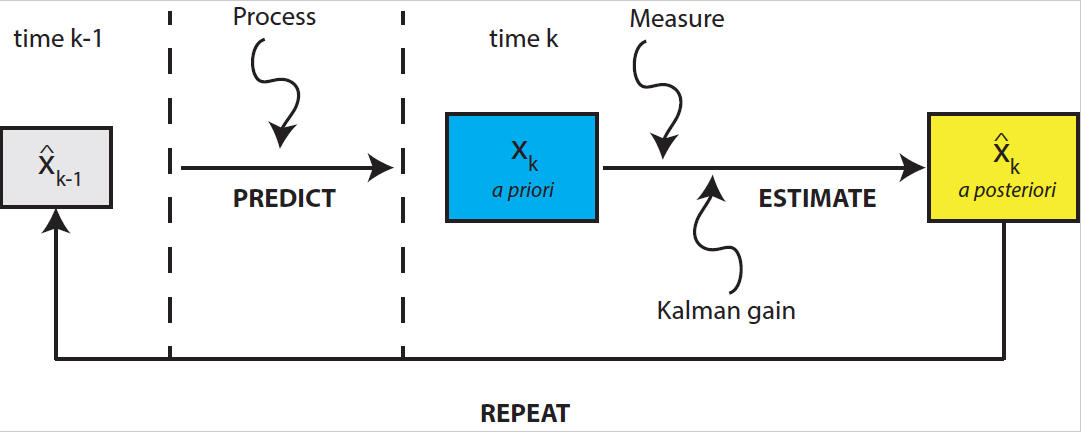

In [8]:
display(Image("images/8_kalman_filter.jpg", embed=True, unconfined=False))

#### 4.4 Kalman filter: non Gaussian case

As we have already noted the optimal state estimate is the mean of conditional probability function: 
$\hat{x}_{k|k} = E[x_{k}|Z_{k}] = \int x_{k}p(x_{k}|Z_{k})dx_{k}$. However, the posterior distribution is usually difficult to calculate. We have seen that it can be done in Gaussian enviroment and the result is the Kalman filter. If we look closer to the Kalman filter equations, we note that the equations can be used to calculate an estimate (and a covariance matrix) regardless of whether the noise assumptions holds. The challenge is to know the whether an estimator is good or not.

*It turns out that if we abandon the full optimality requirements and seek a technique minimizing the MSE within a particular class of estimators, such as the class of **linear estimators**, then the **Kalman filter** is solution of this minimization problem regardless of the distribution of noises.*

The derivation outline is the following. First we constrain that the estimator is the linear function from the measurements: $\hat{x}_{k|k} = A_{k}Z_{k} + b_{k}$. Then we need to select $A_{k}$ and $b_{k}$. They are selected from unbiasedness condition and minimization of mean square error:

$$
E[x_{k} - \hat{x}_{k|k}] = 0 \\
\hat{x}_{k|k} = \underset{A_{k}}{\mathrm{argmin}}\; \; trace\{E[(x_{k} - \hat{x}_{k|k})(x_{k} - \hat{x}_{k|k})^T]\}.
$$

Even if the noise is not Gaussian, the Kalman filter is still the *optimal linear filter*.

It can be easly shown that the solution of this problem is provied by the Kalman filter equations. 

#### 4.5 Kalman filter: Summary

We have linear discrete dynamical system 

$$
{x}_{k} = F_{k}x_{k-1} + B_{k}u_{k} + w_{k} \\
z_{k} = H_{k}x_{k} + r_{k}
$$ 

and we want to optimally estimate its state and optimality criterion is the mean square error: $\hat{x}_{k|k} = {\mathrm{argmin}}E[(x_{k} - \hat{x}_{k|k})(x_{k} - \hat{x}_{k|k})^T]$
 
* If $\{w_{k}\}$ and $\{r_{k}\}$ are ***Gaussian***, zero-mean, uncorrelated, and white, then the Kalman filter is the solution to the above problem. In other words, there is no better estimator than Kalman filter: ***it is the best estimator among all possible estimators***. Estimate is the weighted average of measurement and prediction. 


* If  $\{w_{k}\}$ and $\{r_{k}\}$ are zero-mean, uncorrelated, and white, then the ***Kalman filter is the best linear solution*** to the above problem. That is, the Kalman filter is the best estimator that is a linear combination of the measurements. There may be a *nonlinear filter that gives a better solution*, but the Kalman filter is the best linear filter. 


* The estimated state is the weighted average of predicted state and measurement. Weights are determined based on Kalman gain: the larger the measurement noise variance, the lower the Kalman gain should be and the larger the process state variance, the larger the Kalman gain should be.

$$
K_{k} \sim \frac{Process Noise}{Measurement Noise}.
$$


* If $\{w_{k}\}$ and $\{r_{k}\}$ are correlated or colored, then the Kalman filter can be modified to solve the above problem. 


* For nonlinear systems, ${x}_{k} = f(x_{k-1}, u_{k}, w_{k}), z_{k} = h(x_{k}, r_{k})$ various extensions of Kalman filter are developed to approximate the solution to the above problem.


The algorithm works in a two-step process. In the prediction step, the Kalman filter produces estimates of the current state variables, along with their uncertainties. Once the outcome of the next measurement (necessarily corrupted with some amount of error, including random noise) is observed, these estimates are updated using a weighted average, with more weight being given to estimates with higher certainty. The weights are calculated from the covariance, a measure of the estimated uncertainty of the prediction of the system's state. The result of the weighted average is a new state estimate that lies between the predicted and measured state, and has a better estimated uncertainty than either alone. This process is repeated at every time step, with the new estimate and its covariance informing the prediction used in the following iteration. This means that Kalman filter works recursively and requires only the last "best guess", rather than the entire history, of a system's state to calculate a new state.

    FIGURE 8: Kalman Filter cycle

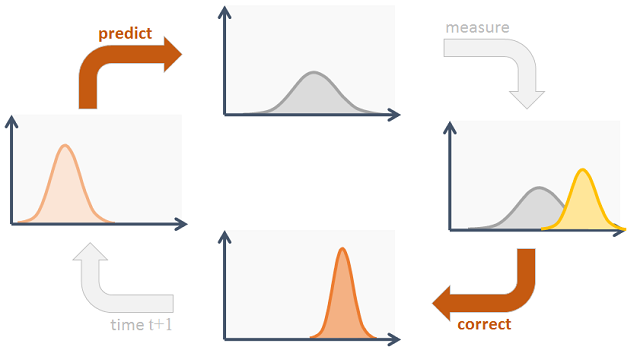

In [9]:
display(Image("images/9_kalman_cycle.png", embed=True, unconfined=False))

## 5. Appendix

#### 5.1 Optimal Bayesian estimation

Before moving to the state estimation of dynamical systems, lets speak about optimal Bayesian estimation in general. 
The general problem of estimation is the estimation of an unobserved value $x$ based on some observed random value $z$. In the classical approach of estimation $x$ is assumed to be a *deterministic but unknown constant*. For example the coefficients of the classical linear regression are treated as unknown but constant values and we find them by minimizing MSE. In Bayesian approach $x$ is treated as a *random variable* whose particular realization we must estimate. In other words $x$ is assumed to have a known *prior probability density function $p(x)$*. This approach allows us to incorporate in our estimator the prior knowledge about the $x$.

To find a suitable estimator we define a cost function, $L$, which defines a penalty for an erroneous estimate $\hat{x} \neq x$. In general, we would prefer cost functions where the penalty increases based on the magnitude of the difference error $e = x - \hat{x}$. Generally Bayesian estimators are defined by a minimization problem

$$
\hat{x} = \underset{x}{\mathrm{argmin}}\iint L(e)p(x, z)dxdz
$$

which seeks for the value of $\hat{x}$ that minimizes the average cost (the expected value of the cost function). The cost function $L(e)$ is typically one of the following

$ \text{1. Quadtratic: } L(e) = e^2$

$ \text{2. Absolute: } L(e) = |e|$

$ \text{3. Hit-or-miss: } L(e) = 
\begin{cases}
    0, & \ |e| < \delta \\
    1, & \ |e| \geq \delta
\end{cases}
$

These three cost functions are favoured, because we can find the minimum cost solution in closed form. 

We are interested in with minimization of the mean square error, so we will concentrate on the quadratic loss function: $L(e) = e^2$. After doing some math, it can be shown, that the solution of the minimization problem in case of quadratic loss function is the following:

$$
\hat{x}_{MMSE} = \underset{x}{\mathrm{argmin}}\iint e^2p(x, z)dxdz = \int xp(x|z)dx = E[x|z].
$$

It is nothing else than the conditional expectation of $x$ given $z$ or the *mean* of *posterior distribution* - $p(x|z)$. It can be shown also that in case of absolute cost function the solution of minimization problem will be the *median* of posterior distribution and in case of Hit-or-miss function the solution will be the *mode* of posterior distribution. The last one is called Maximum a Posteriori (MAP) estimator. 

The posterior distribution function summarizes our knowledge about the $x$ after data is observed. The relationship with prior distribution function is given by the Bayes theorem:

$$
p(x|z) = \frac{p(z|x)p(x)}{p(z)}
$$

where $p(z|x)$ is the likelihood function, which expresses how probable a given set of observations is for different values of $x$ and $p(z) = \int p(z|x)p(x)dx$ is just a normalization constant such the integral of $p(x|z)$ be equal to 1. So taking into consideration the Bayes theorem the MMSE estimator will be:

$$
\hat{x}_{MMSE} = \frac{\int xp(z|x)p(x)dx}{\int p(z|x)p(x)dx}
$$

***Properties of MMSE Estimator:***

* *Unbiasedness*: on average an estimator gives correct estimates.

$$
E[\hat{x}_{MMSE}] = E[E[x|y]] = E[x]
$$

* If $x$ and $z$ are jointly **Gaussian**, then the MMSE estimator is **linear**, i.e., it has the form $\hat{x}_{MMSE}=Wz+b$ for matrix $W$ and vector $b$. This can be directly shown using the Bayes theorem.

So we have general formula for finding the estimator that minimizes the mean-square error, bur in many cases, it is not possible to determine the analytical expression of the MMSE estimator, because there may be computational difficulties because of integration. This is very typical situation in case of multidimensional cases as they involve multidimensional integration. One way of overcoming these difficulties is to directly seek the minima of the MSE using techniques such as the stochastic gradient descent methods, but this method still requires the evaluation of expectation. While this kind of numerical methods can be useful, a closed form expression for the MMSE estimator is nevertheless possible if we are willing to make some compromises.

One possibility is to abandon the full optimality requirements and seek a technique *minimizing the MSE* within a particular class of estimators, such as the class of *linear estimators*. Thus, we postulate that the conditional expectation of $x$ given $z$ is a simple linear function of $z$, $E[x|z]=Wz+b$. This can be seen as the first order Taylor approximation of $E[x|z]$. The linear MMSE estimator is the estimator achieving minimum MSE among all linear estimators. That is, it solves the following the optimization problem:

$$
\underset{W, b}{\mathrm{min}} E[||x - \hat{x}||^2] \quad \text{s.t.} \quad  \hat{x} = Wz + b.
$$

The expression for optimal $W$ and $b$ is given by:

$$
W=P_{xz}P_{z}^{-1}
$$
$$
b=\overline{x} - W\,\,\overline{z}
$$
$$
\Downarrow
$$
$$
\hat{x}_{LMMSE} = W(z - \overline{z}) + \overline{x}
$$

where $\overline{x}=E[x]$, $\overline{z}=E[z]$, the $P_{xz}$ is cross-covariance matrix between $x$ and $y$, the $P_{z}$ is covariance matrix of $z$. The last equation can be interpreted in the following way, to the expected value $\overline{x}$ of the random variable $x$ that we are estimating, the optimal linear estimator adds a suitable multiple of the difference $z − \overline{z}$ between the measured random variable and its expected value.

***Properties of Linear MMSE Estimator:***

* Suboptimal estimator that can be easily implemented.
* Optimal in case of jointly Gaussian PDF.
* No need for explicitly calculation of posterior PDF $p(x|z)$.
* It needs only the first and second moments of the joint PDF.
* The form does not depend on the type of the assumed underlying distribution. 

###### Example

Lets discuss simple example of linear MMSE. Assume that we want to estimate the house prices using some predictors such as area, number of rooms and garages. Lets assume that the relationship between the price and predictors is linear plus some random noise. This can be modeled by the following equation:

$$
z = Ax + v
$$

where $z$ is the price of house or our observation, $A$ is the matrix of predictors, $v$ is the noise with zero mean $E[v] = 0$, zero cross-covaraince $P_{xv}=0$. $x$ represents the unobserved variable - the coefficients of linear relationships. This is very similar to the ordinary linear regression, but there is a significant difference: in OLS we assume that $x$ is the unknown but constant variable, in Bayesian estimation we assume that $x$ is a random variable drawn from some distribution with mean $\overline{x}=E[x]$ and covariance $P_{x}$. For example we may have some prior knowledge that these coefficients are limited in some range, so we can say that they initially are drawn from some uniform distribution $U(a,b)$. If we speak with the language of probability density functions then we should say that $x$ have some prior distribution $p(x)$ and the likelihood function $p(z|x)$ can defined using functional relationship $z = Ax + v$.

The required the required mean and the covariance matrices will be

$$
E[z] = AE[x] = A\overline{x}, \\
P_{z} = AP_{x}A^T + P_{v}, \\
P_{xz} = P_{x}A^T.
$$

Using this formulas we will have

$$
\hat{x}_{LMMSE} = P_{xz}P_{z}^{-1}(z - \overline{z}) + \overline{x} = \\
= P_{x}A^T(AP_{x}A^T + P_{v})^{-1}(z - A\overline{x}) + \overline{x}= \\
= (A^{T}P_{v}^{-1}A + P_{x}^{-1})^{-1}A^TP_{v}^{-1}(z - A\overline{x}) + \overline{x}.
$$

The last equation allows us compare this result with weighted linear regression. In particular, when there is no prior information about $x$, $\overline{x} \to 0$ and $P_{x}^{-1} \to 0$, the last equation becomes:

$$
\hat{x}_{LMMSE} \to (A^{T}P_{v}^{-1}A)^{-1}A^TP_{v}^{-1}z,
$$

which is identical with weighted linear regression ($P_{v}^{-1}$ represents the is the weight matrix). 
Moreover, if the components of noise $v$ are uncorrelated and have equal variance such that $P_{v}=\sigma^2I$, where $I$ is an identity matrix, then we have 

$$
\hat{x}_{LMMSE} \to (A^{T}A)^{-1}A^Tz,
$$

which is identical with the ordinary least square estimate.

###### Summary

The Bayesian approach to estimation of parameter assumes that the parameter to be estimated is a realization of the random variable $x$. As such, we assign prior PDF $p(x)$ to it. After data are observed, our state of knowledge about the parameter is summarized by the posterior PDF $p(x|z)$. An optimal estimator is defined to be the one that minimizes the cost function when averaged over all realizations of $x$ and $z$. In particular case of MSE cost function the estimator is the mean of the posterior PDF or $\hat{x}_{MMSE} = E[x|z]$. 

In many cases this estimator is impossible to express in a closed form due to computational difficulties. In order to overcome this we may seek suboptimal solution: we seek for an estimator which minimizes MSE, but has linear form. This leads to the so called Linear MMSE estimator, which has simple closed form depending only on the first and second moments. It is the best estimator in the class of linear functions and overall best estimator in the case of jointly Gaussian distributed random variables. 

References:

* http://www.unitedthc.com/DSP/Kalman1960.pdf
* https://mathinsight.org/dynamical_system_idea
* https://mathinsight.org/discrete_dynamical_system_introduction
* https://mathinsight.org/discrete_dynamical_system_function_iteration
* https://en.wikipedia.org/wiki/State-space_representation
* https://en.wikipedia.org/wiki/Dynamical_system
* https://medium.com/@jonathan_hui/self-driving-object-tracking-intuition-and-the-math-behind-kalman-filter-657d11dd0a90
* https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19860003843.pdf
* https://cybernetist.com/2019/01/13/apollo-kalman-filter-and-go-filter/
* https://www.cs.unc.edu/~welch/kalman/media/pdf/maybeck_ch1.pdf
* https://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/
* https://share.cocalc.com/share/7557a5ac1c870f1ec8f01271959b16b49df9d087/Kalman-and-Bayesian-Filters-in-Python/08-Designing-Kalman-Filters.ipynb?viewer=share
* https://users.aalto.fi/~ssarkka/course_k2010/
* https://learning.oreilly.com/library/view/introduction-to-random/9780470609699/
* https://learning.oreilly.com/library/view/advanced-kalman-filtering/9781118003169/
* https://www.amazon.com/Optimal-State-Estimation-Nonlinear-Approaches/dp/0471708585